# Modeling Theta and Gamma: Excitatory Inhibitory OLM (EIO) (with BMTK) 

In this notebook we will be modeling nested gamma-theta oscillations. Like the previous 'stochastic weak ping' gamma generating notebook, we will be using excitatory RTM and inhibitory WB cells. We will also be adding the oriens lacunosum-molecular (OLM) cell to provide a slower, endogenous spiking inhibitory input to cells in our network. OLM cells inhibit distal dendrites of pyramidal cells unlike our WB cells. While this network does not account for multi-compartment cells we can simulate the effect by increasing the rise and decay of the OLM synapse [1]. 

When OLM cells periodically inhibit RTM (E) and WB (I) cells a periodic theta rhythm can arrise.

Again, there is no spatial consideration, cell size, position and distance between neurons will play no effect. The primary focus will be on the effects of the OLM cell, synaptic weights, "tau" and strength of external drive. 
As input to drive the simulation, we will also create an external network of "virtual cells" that synapse directly onto our internal cells and provide spike trains stimulus.

This model was inspired by work done in the book "An Introduction to Neuronal Modeling" by C. Borgers. The structural basis for this notebook was inspired by [BMTK](https://github.com/AllenInstitute/bmtk)'s [Tutorial 4](https://github.com/AllenInstitute/bmtk/blob/develop/docs/tutorial/04_multi_pop.ipynb); some text may come directly from this documentation.

**Note** - scripts and files for running this tutorial can be found in the directory [eio_theta_network](https://github.com/cyneuro/rhythms)

requirements:
* bmtk
* NEURON 7.4+

*Contact Tyler Banks (tbanks@mail.missouri.edu with any questions)*

[1] N. H´ajos and I. Mody, Synaptic communication among hippocampal interneurons:
properties of spontaneous IPSCs in morphologically identified
cells, J. Neurosci., 17 (1997), pp. 84278442. 

## 0. Cell Definitions

For reference - template hoc files should be defined in `templates.hoc` and placed in the `components/templates` directory. Cells utilize the following the definitions and include a sodium, potassium, and leak channel. For specific parameters (reversal, conductance, etc.), review the NEURON interfaces provided in the [theta](https://github.com/cyneuro/rhythms/tree/master/theta) directory of the parent folder.

$C \frac{dV_{m}}{dt} = -\bar{g}_{K}n^4(V_{m} - V_{K}) - \bar{g}_{Na}m^3h(V_{m} - V_{Na}) - \bar{g}_{l}(V_{m} - V_{l}) + I$

* $\frac{dn}{dt} = \alpha_{n}(V_{m})(1-n) - \beta_n(V_m)n$
* $\frac{dm}{dt} = \alpha_{m}(V_{m})(1-m) - \beta_m(V_m)m$
* $\frac{dh}{dt} = \alpha_{h}(V_{m})(1-h) - \beta_h(V_m)h$

**RTM Cell**
* $\alpha_{n} = 0.032*(v+52)/(1-e^{-(v+52)/5})$
* $\beta_{n} = 0.5*e^{-(v+57)/40}$
* $\alpha_{m} = 0.32*(v+54)/(1-e^{-(v+54)/4})$
* $\beta_{m} = 0.28*(v+27)/(e^{(v+27)/5}-1)$
* $\alpha_{h} = 0.128*e^{-(v+50)/18}$
* $\beta_{h} = 4./(1+e^{-(v+27)/5})$


**WB Cell**
* $\alpha_{n} = -0.01*(v+34)/(e^{-0.1*(v+34)}-1)$
* $\beta_{n} = 0.125*e^{-(v+44)/80}$
* $\alpha_{m} = 0.1*(v+35)/(1-e^{-(v+35)/10})$
* $\beta_{m} = 4*e^{-(v+60)/18}$
* $\alpha_{h} = 0.07*e^{-(v+58)/20}$
* $\beta_{h} = 1/(e^{-0.1*(v+28)}+1)$

**OLM Cell**

$C \frac{dV_{m}}{dt} = -\bar{g}_{K}n^4(V_{m} - V_{K}) - \bar{g}_{Na}m^3h(V_{m} - V_{Na}) - \bar{g}_{l}(V_{m} - V_{l}) -\bar{g}_{h}r(V_{m} - V_{h}) -\bar{g}_{A}ab(V_{m} - V_{A}) + I$


* $\frac{dn}{dt} = \alpha_{n}(V_{m})(1-n) - \beta_n(V_m)n$
* $\frac{dm}{dt} = \alpha_{m}(V_{m})(1-m) - \beta_m(V_m)m$
* $\frac{dh}{dt} = \alpha_{h}(V_{m})(1-h) - \beta_h(V_m)h$
* $\frac{dr}{dt} = \frac{r_{\infty} - r}{\tau_{r}}$
* $\frac{da}{dt} = \frac{a_{\infty} - a}{\tau_{a}}$
* $\frac{db}{dt} = \frac{b_{\infty} - b}{\tau_{b}}$


* $\alpha_{n} = -0.018*(v-25)/(1-e^{-(v-25)/25})$
* $\beta_{n} = 0.0036/(1-e^{-(35-v)/12})$
* $\alpha_{m} = 0.1*(v+38)/(1-e^{-(v+38)/10})$
* $\beta_{m} = 4*e^{-(v+65)/18}$
* $\alpha_{h} = 0.07*e^{-(v+63)/20}$
* $\beta_{h} = 1/(1+ e^{-(v+33)/10})$
* $r_{\infty} = 1/(1+e^{(v+84)/10.2})$
* $\tau_{r} = 1/(e^{-14.59-0.086*v}+e^{-1.87+0.0701*v})$
* $a_{\infty} = 1/(1+e^{-(v+14)/16.6})$
* $\tau_{a} = 5$
* $b_{\infty} = 1/(1+e^{(v+71)/7.3})$
* $\tau_{b} = \frac{1}{\frac{0.000009}{exp{(v-26)/28.5}}+\frac{0.014}{0.2+e^{-(v+70)/11}}}$


#### OLM h and A channels
You may notice that the OLM cell has two additional channels, h and A. The h channel causes the neuron to accelerate more quickly. It's open at lower voltages and closed when the cell is spiking at higher voltages. Even without providing current, the cell spikes. See the accompanying NEURON interface to "play" with the cell (`../theta/cell_tester_olm_h.hoc`).

The 'A' current is a slowly decaying hyperpolarizing potassium current, raised by firing. This transient channel has an inactivation gate.  Inactivation is fast and de-inactivation is slow. When a neuron fires the current briefly rises but when the potential falls the current rapidly follows. This is due to the 'a' gate short inactivation. The end result: A-current adds tonic inhibition. To play with an OLM cell with the h and A channels see (`../theta/cell_tester_olm_ha.hoc`).

#### Current Channels .mod files
Mod files for the sodium, potassium and leak channels are defined in the `components/mechanisms` folder. The RTM Sodium channel contents of `components/mechanisms/na_rtm.mod` are shown below. See the additional `k_rtm.mod`, `na_wb.mod`, `k_wb.mod`, and `leak.mod` files in the same directory. Definitions above.

#### !! Be sure to compile the mechanism files in `components/mechanisms` before continuing !! (nrnivmodl or mknrndll)

## 1. Building the network

#### Cells

This network will loosely resemble the rodent hippocampals. There will be a population of 300 detailed neurons: 200 excitatory RTM cells, 50 inhibitory WB cells, and 50 OLM cells.

Below, we create our network `net` object definition using BMTK. We then instruct the `net` object to `add_nodes` to our network model.

In [ ]:
import os

RunningInCOLAB = 'google.colab' in str(get_ipython())  # checks to see if we are in google colab
if RunningInCOLAB:                                     # installs packages and repo if in colab
    !pip install bmtk &> /dev/null               
    !pip install neuron &> /dev/null
    !git clone https://github.com/GregGlickert/Neural-Modeling-Manual.git &> /dev/null 
    %cd Neural-Modeling-Manual/Chapter-5-Building-Networks/Section-X-Full-network-models/eio_theta_network

if(os.path.exists('components/mechanisms/x86_64')==False): 
    %cd components/mechanisms/       
    os.system('nrnivmodl') # compile modfiles. Return 0 for success, 1 for failure.
    %cd ../..

In [1]:
import numpy as np
import logging

from bmtk.builder.networks import NetworkBuilder

n_E = 200 # number of RTM excitatory cells
n_I = 50  # number WB inhibitory cells
n_O = 50  # number of OLM cells
    

net = NetworkBuilder('network')

net.add_nodes(N=n_I, pop_name='Inh',     # N = number of inhibitory cells
        model_type='biophysical',
        model_template='hoc:WBInhCell',  # WBInhCell hoc definition
        morphology='blank.swc')

net.add_nodes(N=n_E, pop_name='Exc',     # N = number of excitatory cells
        model_type='biophysical',
        model_template='hoc:RTMExcCell', # RTMExcCell hoc definition
        morphology='blank.swc')

net.add_nodes(N=n_I, pop_name='Olm',     # N = number of OLM cells
        model_type='biophysical',
        model_template='hoc:OLMhaCell',  # OLMhaCell hoc definition
        morphology='blank.swc')


#### Connections

Now we want to create connections between the cells. Depending on the model type, and whether or not the presynpatic "source" cell is excitory or inhibitory, we will have different synpatic model and parameters. Using the source and target filter parameters, we can create different connection types

To do this we create a customized function `syn_connector` which accepts the probability parameter `p`.

In [2]:
import random

def syn_connector(source,target,p):
    return 1 if random.random() < p else 0

The first two parameters of this function are "source" and "target" and are required for all custom connector functions. These are node objects which gives a representation of a single source and target cell, with properties that can be accessed like a python dictionary. When The Network Builder is creating the connection matrix, it will call this function for all possible source-target pairs. The user doesn't call this function directly.

In `syn_connector`, cells will be connected based on randomized probability. For example, if `p` is set to `.5`, on average, half of the cells will be connected. This function also determines the number of connections between each given source and target cell, in this case we only have one connection but this can be changed if desired. If there are none you can return either None or 0.

To create these connections we call add_edges method of the builder. We use the source and target parameter to filter out only excitory-to-excitory and then excitatory-to-inhibitory connections. We pass in the custom connector function through the connection_rule parameter, and the function parameters (except source and target) through connection_params. (If our `syn_connector` function didn't have any parameters other than source and target, we could just not set connection_params).

The probability that two cell types are connected is governed by
* $p_{EE}$ (`p_EE`) - Probability of Excitatory RTM Cells Connecting to Excitatory RTM Cells
* $p_{EI}$ (`p_EI`) - Probability of Excitatory RTM Cells Connecting to Inhibitory WB Cells
* $p_{IE}$ (`p_IE`) - Probability of Inhibitory WB Cells Connecting to Excitatory RTM Cells
* $p_{II}$ (`p_II`) - Probability of Inhibitory WB Cells Connecting to Inhibitory WB Cells

* $p_{EO}$ (`p_EO`) - Probability of Excitatory RTM Cells Connecting to Inhibitory OLM Cells
* $p_{IO}$ (`p_IO`) - Probability of Inhibitory WB Cells Connecting to Inhibitory OLM Cells
* $p_{OE}$ (`p_OE`) - Probability of Inhibitory OLM Cells Connecting to Excitatory RTM Cells
* $p_{OI}$ (`p_OI`) - Probability of Inhibitory OLM Cells Connecting to Inhibitory WB Cells
* $p_{OO}$ (`p_OO`) - Probability of Inhibitory OLM Cells Connecting to Inhibitory OLM Cells


The **maximum** conductance that can be provided by all input of a specific cell type is provided by $\hat{g}_{XX}$
* $\hat{g}_{EE}$ (`g_hat_EE`) - RTM to RTM connections
* $\hat{g}_{EI}$ (`g_hat_EI`) - RTM to WB connections
* $\hat{g}_{IE}$ (`g_hat_IE`) - WB to RTM connections
* $\hat{g}_{II}$ (`g_hat_II`) - WB to WB connections

* $\hat{g}_{EO}$ (`g_hat_EO`) - RTM to OLM connections
* $\hat{g}_{IO}$ (`g_hat_IO`) - WB to OLM connections
* $\hat{g}_{OE}$ (`g_hat_OE`) - OLM to RTM connections
* $\hat{g}_{OI}$ (`g_hat_OI`) - OLM to WB connections
* $\hat{g}_{OO}$ (`g_hat_OO`) - OLM to OLM connections


In [3]:
p_EE = 1.0 # Probability of Excitatory RTM Cells Connecting to Excitatory RTM Cells
p_EI = 1.0 #0.5 # Probability of Excitatory RTM Cells Connecting to Inhibitory WB Cells
p_IE = 1.0 #0.5 # Probability of Inhibitory WB Cells Cells Connecting to Excitatory RTM Cells
p_II = 1.0 #0.5 # Probability of Inhibitory WB Cells Cells Connecting to Inhibitory WB Cells
p_EO = 1.0
p_IO = 1.0
p_OE = 1.0
p_OI = 1.0
p_OO = 1.0

g_hat_EE = 0.0
g_hat_EI = 0.25
g_hat_IE = 0.25
g_hat_II = 0.25
g_hat_EO = 0.0
g_hat_IO = 0.5
g_hat_OE = 1.0
g_hat_OI = 0.5
g_hat_OO = 0.0

conn = net.add_edges(source={'pop_name':'Exc'}, target={'pop_name':'Exc'},
            connection_rule=syn_connector,
            connection_params={'p':p_EI},
            syn_weight=g_hat_EE/n_E, # Synaptic weight is g^ over the total number of cell in the population
            dynamics_params='ExcToExc.json',
            model_template='exp2syn',
            distance_range=[0.0,999.9],
            delay=0,
            target_sections=['soma'])

conn = net.add_edges(source={'pop_name':'Exc'}, target={'pop_name':'Inh'},
            connection_rule=syn_connector,
            connection_params={'p':p_EI},
            syn_weight=g_hat_EI/n_E, # Synaptic weight is g^ over the total number of cell in the population
            dynamics_params='ExcToInh.json',
            model_template='exp2syn',
            distance_range=[0.0,999.9],
            delay=0,
            target_sections=['soma'])


Similarly we create the other inhibitory connections.

In [4]:

conn = net.add_edges(source={'pop_name':'Inh'}, target={'pop_name':'Exc'},
            connection_rule=syn_connector,
            connection_params={'p':p_IE},
            syn_weight=g_hat_IE/n_I, # Synaptic weight is g^ over the total number of cell in the population
            dynamics_params='InhToExc.json',
            model_template='exp2syn',
            distance_range=[0.0,999.9],
            delay=0,
            target_sections=['soma'])


conn = net.add_edges(source={'pop_name':'Inh'}, target={'pop_name':'Inh'},
            connection_rule=syn_connector,
            connection_params={'p':p_II},
            syn_weight=g_hat_II/n_I, # Synaptic weight is g^ over the total number of cell in the population
            dynamics_params='InhToInh.json',
            model_template='exp2syn',
            distance_range=[0.0,999.9],
            delay=0,
            target_sections=['soma'])



Finally, all connections relating to OLM type cells.

In [5]:

conn = net.add_edges(source={'pop_name':'Exc'}, target={'pop_name':'Olm'},
            connection_rule=syn_connector,
            connection_params={'p':p_EO},
            syn_weight=g_hat_EO/n_E, # Synaptic weight is g^ over the total number of cell in the population
            dynamics_params='ExcToInh.json',
            model_template='exp2syn',
            distance_range=[0.0,999.9],
            delay=0,
            target_sections=['soma'])

conn = net.add_edges(source={'pop_name':'Inh'}, target={'pop_name':'Olm'},
            connection_rule=syn_connector,
            connection_params={'p':p_IO},
            syn_weight=g_hat_IO/n_I, # Synaptic weight is g^ over the total number of cell in the population
            dynamics_params='InhToInh.json',
            model_template='exp2syn',
            distance_range=[0.0,999.9],
            delay=0,
            target_sections=['soma'])

conn = net.add_edges(source={'pop_name':'Olm'}, target={'pop_name':'Exc'},
            connection_rule=syn_connector,
            connection_params={'p':p_OE},
            syn_weight=g_hat_OE/n_O, # Synaptic weight is g^ over the total number of cell in the population
            dynamics_params='OlmToExc.json',
            model_template='exp2syn',
            distance_range=[0.0,999.9],
            delay=0,
            target_sections=['soma'])

conn = net.add_edges(source={'pop_name':'Olm'}, target={'pop_name':'Inh'},
            connection_rule=syn_connector,
            connection_params={'p':p_OI},
            syn_weight=g_hat_OI/n_O, # Synaptic weight is g^ over the total number of cell in the population
            dynamics_params='OlmToInh.json',
            model_template='exp2syn',
            distance_range=[0.0,999.9],
            delay=0,
            target_sections=['soma'])

conn = net.add_edges(source={'pop_name':'Olm'}, target={'pop_name':'Olm'},
            connection_rule=syn_connector,
            connection_params={'p':p_OO},
            syn_weight=g_hat_OO/n_O, # Synaptic weight is g^ over the total number of cell in the population
            dynamics_params='OlmToInh.json',
            model_template='exp2syn',
            distance_range=[0.0,999.9],
            delay=0,
            target_sections=['soma'])

#### Synaptic properties

For this model, we'll be using `NEURON`'s built-in [`exp2syn`](https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/mechanisms/mech.html#Exp2Syn) synapse, which will provide simple rise and decay dynamics. 

You may have noticed the `dynamics_params` parameter in the previous `add_edges` function calls. These files contain values that will be passed to the simulator at runtime. They'll located in the `components/synaptic_models` directory. We'll need four separate files - `PING_ExcToExc.json` for excitatory to excitatory, `ExcToInh.json` for excitatory to inhibitory, `InhToExc.json` for inhibitory to excitatory, and `InhToInh.json` for inhibitory to inhibitory connections. There is an additional set of OLM type synapses as well, `OlmToExc.json` and `OlmToInh.json`. An example of one is shown below. **Edit these files directly** (and not here), before running the simulation to test different synaptic parameters.


```json
{
    "tau1": 0.5,
    "tau2": 3,
    "erev": 0
}
```

`"tau1"` is the synapse rise time, `"tau1"` is the decay, and `"erev"` is the reversal potential.

Again, OLM Cells are inhibitory, just like the WB cells but their decay time will be set to nearly twice that of WB.

#### Building

Finally we build the network (this may take a bit of time since it's iterating over all 250x250 possible connection combinations), and save the nodes and edges.

In [6]:
net.build()
net.save_nodes(output_dir='network')
net.save_edges(output_dir='network')

### Building external network

Next we want to create an external network consisting of virtual cells that form a feedforward network onto our PING network, which will provide input during the simulation. We will call this `extnet`, (if we wanted to we could also create multiple external networks and run simulations on any number of them). 

First we build our `extnet` nodes. Then we must import the `network` nodes, and create connections between `extnet` --> `network`.

In [7]:
from bmtk.builder.networks import NetworkBuilder

extnet = NetworkBuilder('extnet')

extnet.add_nodes(N=n_E, model_type='virtual', pop_name='bgnoisevirtExt', pop_group='bgnoisevirtExt')


As before, we will use a customized function to determine the number of connections between each source and target pair, however this time our connection_rule is a bit different

In the previous example, our connection_rule function's first two arguments were the presynaptic and postsynaptic cells, which allowed us to choose how many synaptic connections between the pairs existed based on individual properties:
```python
def connection_fnc(source, target, ...):
    source['param'] # presynaptic cell params
    target['param'] # postsynaptic cell params
    ...
    return nsyns # number of connections between pair
```

But for our `extnet` --> `network` connection, we do things a bit differently. We want to make sure that for every source cell, there are a limited number of presynaptic targets or in this case, exactly 1. This is a not really possible with a function that iterates on a one-to-one basis. So instead we have a connector function who's first parameter is a single source cell, and the second parameter is a list of N target cells. We return an array of integers, size N; which each index represents the number of synapses between source and the targets. 

To tell the builder to use this schema, we must set `iterator='one_to_all'` in the `add_edges` method. (By default this is set to 'one_to_one'. You can also use 'all_to_one' iterator which will pass in all possible single sources and a single target).

In [8]:
def target_ind_equals_source_ind(source, targets, offset=0, min_syn=1,max_syn=1):
    # Creates a 1 to 1 mapping between source and destination nodes
    total_targets = len(targets)
    syns = np.zeros(total_targets)
    target_index = source['node_id']
    syns[target_index-offset] = 1
    return syns
        

g_bar_stoch = 0.03
    
conn = extnet.add_edges(target=net.nodes(pop_name='Exc'),
            source={'pop_name':'bgnoisevirtExt'},
            iterator='one_to_all',
            connection_rule=target_ind_equals_source_ind,
            connection_params={'offset':n_I},
            dynamics_params='ExcToExc.json',
            model_template='exp2syn',
            distance_range=[0.0,999.9],
            target_sections=['soma'],
            delay=0,
            syn_weight=g_bar_stoch
            )

extnet.build()
extnet.save_nodes(output_dir='network')
extnet.save_edges(output_dir='network')

In the above code, we have our `extnet` object `add_edges` where the target cell type's `pop_name` is `'Exc'` in the `net` network. The strength of the external input is defined by $\bar{g}_{stoch}$ (`g_bar_stoch`). 

**!! Change the value of $\bar{g}_{stoch}$ (`g_bar_stoch`) to determine the effect of external input (provided to our excitatory cells) on the gamma frequency!!**

## 2. Setting up BioNet

#### file structure.

Before running a simulation, we will need to create the runtime environment, including parameter files, run-script and configuration files. We will copy the other necessary files from an existing simuation. The following command has been executed for us:

```bash
$ python -m bmtk.utils.sim_setup  \
   --network network              \
   --dt 0.1                       \
   --tstop 1000.0                 \
   bionet .
```

$ python -m bmtk.utils.sim_setup --network network --dt 0.1 --tstop 1000.0 bionet .

It can also be run directly in python (see commented out code)

In [9]:
from bmtk.utils.sim_setup import build_env_bionet

sim_len = 1000.0
dt = 0.1

# This step has already been performed for you. 
# Running again will remove customized configuration files. 
# If you wish to run again, remove comment tags below.

#build_env_bionet(base_dir='.',
#                 network_dir='network',
#                 tstop=500.0, dt=0.1,
#                  current_clamp={            
#                    'amp': 0.400,
#                    'delay': 0,
#                   'duration': 3000.0,
#                    'gids':'all'
#                  },
#                 include_examples=False,    
#                 compile_mechanisms=False,  
#                 config_file ='config.json',
#                 overwrite_config=True
#                )


This will fill out the our current directory with all the files we need to get started to run the simulation. Of interest includes

* **circuit_config.json** - A configuration file that contains the location of the network files we created above. Plus location of neuron and synpatic models, templates, morphologies and mechanisms required to build our instantiate individual cell models.


* **simulation_config.json** - contains information about the simulation. Including initial conditions and run-time configuration (_run_ and _conditions_). In the _inputs_ section we define what external sources we will use to drive the network (in this case a current clamp). And in the _reports_ section we define the variables (soma membrane potential and calcium) that will be recorded during the simulation 


* **run_bionent.py** - A script for running our simulation outside of our Jupyter notebook. Usually this file doesn't need to be modified.

* **components/synaptic_models/** - Parameter files used to create different types of synapses.


#### circuit_config.json
The `circuit_config.json` file will need to be modified to specify our network configuration files generated previously. Your `"networks"` section should look like the following. These files were generated previously with our `save_nodes` and `save_edges` function calls.

```json
  "networks": {
    "nodes": [
      {
        "nodes_file": "$NETWORK_DIR/network_nodes.h5",
        "node_types_file": "$NETWORK_DIR/network_node_types.csv"
      },
      {
        "nodes_file": "$NETWORK_DIR/extnet_nodes.h5",
        "node_types_file": "$NETWORK_DIR/extnet_node_types.csv"
      }
    ],
    "edges": [
      {
        "edges_file": "$NETWORK_DIR/network_network_edges.h5",
        "edge_types_file": "$NETWORK_DIR/network_network_edge_types.csv" 
      },
      {
        "edges_file": "$NETWORK_DIR/extnet_network_edges.h5",
        "edge_types_file": "$NETWORK_DIR/extnet_network_edge_types.csv" 
      }
    ],
    "gap_juncs": []
  }
```

#### External Input

We need to provide two types of input to our cells. First, to our `extnet` external network cells with spike-trains so they can activate our network in a synchronized mannor. Second, a constant current injection to increase all cell's excitability.

First, we must edit the **simulation_config.json** file to tell the simulator to find the **.h5** files and which network to associate it with. **This has already been done for you**

```json
{
  "node_sets": {
    "Exc": {
      "pop_name":"Exc"
    }
  },
  "inputs": {
    "noise": {
      "input_type": "spikes",
      "module": "sonata",
      "input_file": "input/ext_inp_poisson.h5",
      "node_set": "exc"
    },
    "file_current_clamp": {
      "input_type": "file_current_clamp",
      "module": "FileIClamp",
      "input_file":"input/amps.h5",
      "node_set":"all"
    }
  }
}
```

In the `"node_sets"` section we specify a set of nodes that we want input provided to.

Next, we need to generate the previously specified `input/ext_inp_poisson.h5` file. The implementation details of this section of code aren't important but what we need to do is provide each artificial cell a poisson input drive at the $f_{stoch}$ (`stoch_freq`) frequency.

In [10]:
def generate_ext_poisson_input(n_E,freq=60,offset=0,population='extnet',times=(0.0, 1.0),filename='input/ext_inp_poisson.h5'):
    '''
    Generate poisson input for ext cells
    '''
    import os
    from bmtk.utils.reports.spike_trains import PoissonSpikeGenerator
    
    try:
        os.remove(filename)
    except OSError:
        pass
    
    psg = PoissonSpikeGenerator(population=population)
    psg.add(node_ids=range(offset,offset+n_E),  # Select nodes
            firing_rate=freq,     # 'freq' Hz, we can also pass in a nonhomoegenous function/array
            times=times)    # Firing starts at 0 s up to 1 s by default
    psg.to_sonata(filename)
    logging.info(filename + " written")


#n_E defined above
stoch_freq = 60

generate_ext_poisson_input(n_E,freq=stoch_freq,filename='input/ext_inp_poisson.h5')


**!! Alter the value of $f_{stoch}$ (`stoch_freq`) to increase of decrease the input drive!!** 

Now we need to generate a constant current drive for both RTM and WB cells. 

The *i*-th excitatory cell and *j*-th inhibitory cell receives the following input drives respecively:

* $I_{E,i} = \bar{I}_{E}(1+\sigma_{E}X_{i})$ 
* $I_{I,j} = \bar{I}_{I}(1+\sigma_{I}X_{j})$ 

Where $X_{i}$ and $Y_{j}$ are independent Gaussians.

In [11]:
import h5py

I_bar_E = 1.8
sigma_E = 0.05
I_bar_I = 1.0
sigma_I = 0.1
I_bar_O = -2.0
sigma_O = 0.05

samples = int(sim_len/dt)
amp = np.zeros((n_E+n_I+n_O,samples))

#amp[:n_E,:] = (I_bar_E * (1 + sigma_E*np.random.normal(size=n_E))).reshape(-1,1) # Excitatory Cell Current Injection
#amp[n_E:,:] = (I_bar_I * (1 + sigma_I*np.random.normal(size=n_I))).reshape(-1,1) # Inhibitory Cell Current Injection

amp[n_I+n_E:,:] = (I_bar_O * (1 + sigma_O*np.random.normal(size=n_O))).reshape(-1,1) # OLM Cell Current Injection
amp[n_I:n_I+n_E,:] = (I_bar_E * (1 + sigma_E*np.random.normal(size=n_E))).reshape(-1,1) # Excitatory Cell Current Injection
amp[:n_I,:] = (I_bar_I * (1 + sigma_I*np.random.normal(size=n_I))).reshape(-1,1) # Inhibitory Cell Current Injection


dts = [1]
gids = "all"

#hf.close() # Uncomment this line temporarily if you receive 'file already open error'

hf = h5py.File("input/amps.h5", 'w')

hf.create_dataset("amplitudes", data=[amp])
hf.create_dataset("gids", data=gids)
hf.create_dataset("dts", data=dts)

hf.close()

In [12]:
display(amp)

array([[ 0.92904724,  0.92904724,  0.92904724, ...,  0.92904724,
         0.92904724,  0.92904724],
       [ 0.87821676,  0.87821676,  0.87821676, ...,  0.87821676,
         0.87821676,  0.87821676],
       [ 0.85333033,  0.85333033,  0.85333033, ...,  0.85333033,
         0.85333033,  0.85333033],
       ...,
       [-2.10399039, -2.10399039, -2.10399039, ..., -2.10399039,
        -2.10399039, -2.10399039],
       [-2.26418295, -2.26418295, -2.26418295, ..., -2.26418295,
        -2.26418295, -2.26418295],
       [-2.03869485, -2.03869485, -2.03869485, ..., -2.03869485,
        -2.03869485, -2.03869485]])

### 3. Running the simulation

Finally we are ready to run the simulation. Note that because this is a 300 cell simulation, this may be computationally intensive for some older computers and may take anywhere between a few seconds to a few minutes to complete.


In [1]:
from bmtk.simulator import bionet

#### The following two lines are not needed in newer versions of BMTK but retained for compatibility
from bmtk.simulator.bionet.default_setters.cell_models import loadHOC
bionet.pyfunction_cache.add_cell_model(loadHOC, directive='hoc', model_type='biophysical')
####

conf = bionet.Config.from_json('config.json')
conf.build_env()
net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

2024-03-10 18:44:20,675 [INFO] Created log file
2024-03-10 18:44:20,778 [INFO] Building cells.
2024-03-10 18:44:21,084 [INFO] Building recurrent connections
2024-03-10 18:44:40,597 [INFO] Building virtual cell stimulations for noise
2024-03-10 18:44:40,812 [INFO] Running simulation for 600.000 ms with the time step 0.100 ms
2024-03-10 18:44:40,813 [INFO] Starting timestep: 0 at t_sim: 0.000 ms
2024-03-10 18:44:40,814 [INFO] Block save every 5000 steps
2024-03-10 18:45:00,970 [INFO]     step:5000 t_sim:500.00 ms
2024-03-10 18:45:04,967 [INFO]     step:6000 t_sim:600.00 ms
2024-03-10 18:45:04,994 [INFO] Simulation completed in 24.18 seconds 


## 4. Analyzing results

Results of the simulation, as specified in the config, are saved into the output directory. Using the analyzer functions, we can do things like plot the raster plot

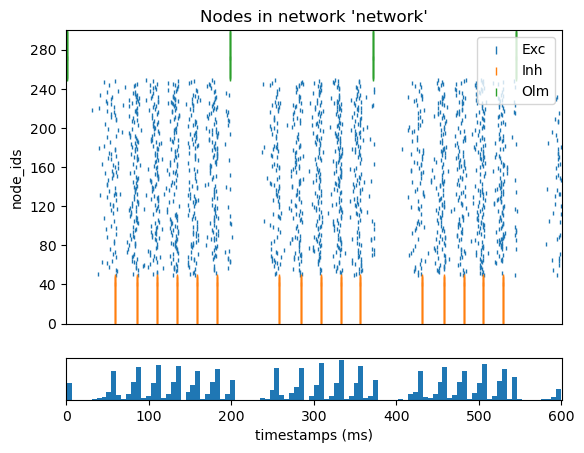

The OLM network is oscilating around 5.506608 hz
The Inh network is oscilating around 31.914894 hz


In [9]:
from bmtk.analyzer.spike_trains import plot_raster, plot_rates_boxplot
import h5py
import pandas as pd
import numpy as np

plot_raster(config_file='config.json', group_by='pop_name')
f = h5py.File('output/spikes.h5')
spikes_df = pd.DataFrame({'node_ids': f['spikes']['network']['node_ids'], 'timestamps': f['spikes']['network']['timestamps']})
cells = range(280,281)
cell_spikes = spikes_df[spikes_df['node_ids'].isin(cells)]
sorted_spikes = np.sort(cell_spikes['timestamps'])
ISI = np.diff(sorted_spikes)
mean_ISI = np.mean(ISI)
freq = 1000/mean_ISI
print("The OLM network is oscilating around {:f} hz".format(freq))
cells = range(5,6)
cell_spikes = spikes_df[spikes_df['node_ids'].isin(cells)]
sorted_spikes = np.sort(cell_spikes['timestamps'])
ISI = np.diff(sorted_spikes)
threshold = 50  # drop gap between gamma cycles
filtered_ISI = ISI[ISI <= threshold]
mean_ISI = np.mean(ISI)
freq = 1000/mean_ISI
print("The Inh network is oscilating around {:f} hz".format(freq))


and the rates of each node

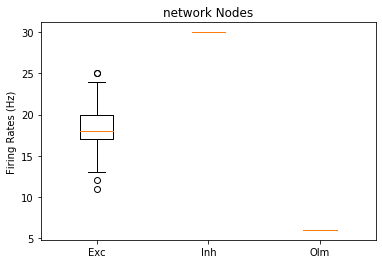

In [ ]:
plot_rates_boxplot(config_file='simulation_config.json', group_by='pop_name')

Improvements to this network can be made by randomizing the state variables of the cells. As you can see, all OLM cells fire at the same time. By randomizing we would see a less tight coupling.